#SPDX-FileCopyrightText: 2024 David Fernandes del Pozo <david.fernandesdelpozo@ugent.be>, <fernandesdelpozo.david@gmail.com>

#SPDX-License-Identifier: GPL-3.0

# BSM1 Model with Tacáks settler model

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from   scipy.integrate import ode, odeint, solve_ivp
from   tqdm.notebook import tqdm_notebook
from   tqdm import tqdm


# Prints current Python version
print("Current version of Python is ", sys.version)
print("Current version of Scipy is ", scipy.__version__)


# Change some matplotlib settings
plt.rcParams
matplotlib.rcdefaults()
plt.rcParams['mathtext.fontset'] = "cm"

Current version of Python is  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Current version of Scipy is  1.11.1


### Steady State BSM1 values for Influent feed

In [2]:
# Average feed load concentrations
df_SS_inlet = pd.DataFrame([[30,69.5,51.2,202.32,28.17,0,0,0,0,31.56,6.95,10.59,7,18446]])
df_SS_inlet.columns =      ['SI','SS','XI','XS','XBH','XBA','XP','SO','SNO','SNH','SND','XND','SALK','Q']

In [3]:
# Average Feed load concentrations
SIf  = df_SS_inlet['SI'][0]        # [g COD/m³] 
SSf  = df_SS_inlet['SS'][0]        # [g COD/m³]  
XIf  = df_SS_inlet['XI'][0]        # [g COD/m³] 
XSf  = df_SS_inlet['XS'][0]        # [g COD/m³]
XBHf = df_SS_inlet['XBH'][0]       # [g COD/m³]
XBAf = df_SS_inlet['XBA'][0]       # [g COD/m³]
XPf  = df_SS_inlet['XP'][0]        # [g COD/m³]
SOf  = df_SS_inlet['SO'][0]        # [g COD/m³]
SNOf = df_SS_inlet['SNO'][0]       # [g NO/m³]
SNHf = df_SS_inlet['SNH'][0]       # [g NH/m³]
SNDf = df_SS_inlet['SND'][0]       # [g N/m³]
XNDf = df_SS_inlet['XND'][0]       # [g N/m³]

### Define the ASM + BSM1 model constants and parameters

In [4]:
# Stoichiometry 
YA  = 0.24;     # Autotrophic yield                                         [g COD formed/(g N oxidized)]
YH  = 0.67;     # Heterotrophic yield                                       [g COD formed/(g COD oxidized)]
fP  = 0.08;     # Fraction of biomass yielding particulate products         [-]
iXB = 0.08;     # Mass of nitrogen per mass of COD in biomass               [g N/(g COD) in biomass] 
iXP = 0.06;     # Mass of nitrogen per mass of COD in products from biomass [g N/(g COD) in particulate products]

# Kinetics parameters
µH    = 4.0;    # Max. specific growth rate for heterotrophic biomass                          [1/d]
KS    = 10;     # Half-saturation coefficient for heterotrophic biomass                        [g/m³]
KOH   = 0.2;    # Oxygen half-saturation coefficient for heterotrophic biomass                 [g/m³]
KNO   = 0.5;    # Nitrate half-saturation coefficient for denitrifying heterotrophic biomass   [g/m³]
bH    = 0.3;    # Decay coefficient for heterotrophic biomass                                  [1/d]
etag  = 0.8;    # Correction factor for muH under anoxic conditions                            [-]
etah  = 0.8;    # Correction factor for hydrolysis under anoxic conditions                     [-]
kh    = 3.0;    # Maximum specific hydrolysis rate                                             [1/d]
KX    = 0.1;    # Half-saturation coefficient for hydrolysis of slowly biodegradable substrate [-]
µA    = 0.5;    # Maximum specific growth rate for autotrophic biomass                         [1/d]
KNH   = 1;      # Ammonia half-saturation coefficient for autotrophic biomass                  [g/m³]
KOA   = 0.4;    # Oxygen half-saturation coefficient for autotrophic biomass                   [g/m³]
bA    = 0.05;   # Decay coefficient for autotrophic biomass                                    [1/day]
ka    = 0.05;   # Ammonification rate                                                          [m³/g/day]
kLa   = 240;    # Oxygen mass transfer coefficient                                             [1/d] 
## Close loop value = 3.5 [1/h]
kLa_5 = 84;     # Oxygen mass transfer coefficient of 5th tank                                 [1/day]
SOsat = 8;      # Oxygen saturation concentration                                              [g/m³]

### Flow Rates

In [5]:
# Definition of flow rates
Qf = df_SS_inlet['Q'][0]    # [m³/d]           
# Wastage flow rate (to control solids accumulation and purge inerts) 
Qw =  385                   # [m³/d]          
# Flow rate of internal recirculation (assumed to be based on the feed flow rate at that instant)
Qa = 3*Qf                   # [m³/d]
# Inflow to settler
Qo = 2*Qf                   # [m³/d]
# Underflow from settler
Qs = Qf+Qw                  # [m³/d]
# Overflow from settler
Qe = Qf-Qw                  # [m³/d]     
# Recirculated flow rate from settler 
Qr = Qf                     # [m³/d]          
# Recirculation flow rate from settler and for denitrification
Qra = Qa + Qr               # [m³/d]
# Inlet flow rate of aerated tanks 
Qi = Qf + Qra               # [m³/d]  
# Flow rates between tanks
Q1 = Q2 = Q3 = Q4 = Qi      # [m³/d]

# Definition of volumes    
V1,V2,V3,V4,V5 = 1000,1000,1333,1333,1333 # [m³/d]

### Activated Sludge Model No.1 (ASM1)

In [6]:
#•Define ASM Process rates
def process_rates(SS, XS, XBH, XBA, XP, SO, SNO, SNH, SND, XND):
    '''Process rates'''

    rho = np.zeros(8)
    # Aerobic growth of heterotrophs
    rho[0] = µH*(SS/(KS+SS))*(SO/(KOH+SO))*XBH
    # Anoxic growth of heterotrophs
    rho[1] = µH*(SS/(KS+SS))*(KOH/(KOH+SO))*(SNO/(KNO+SNO))*etag*XBH
    # Aerobic growth of autotrophs
    rho[2] = µA*(SNH/(KNH+SNH))*(SO/(KOA+SO))*XBA
    # Decay of heterotrophs
    rho[3] = bH*XBH
    # Decay of autotrophs
    rho[4] = bA*XBA
    # Ammonification of soluble organic nitrogen
    rho[5] = ka*SND*XBH
    # Hydrolysis of entrapped organics
    rho[6] = kh*((XS/XBH)/(KX+(XS/XBH)))*(((SO/(KOH+SO))) \
             + etah*(KOH/(KOH+SO))*(SNO/(KNO+SNO)))*XBH
    # Hydrolysis of entrapped organic nitrogen
    rho[7] = rho[6]*(XND/XS)
    
    return rho

#•Define ASM Conversion rates 
def conversion_rates(rho):
    '''conversion rates'''

    r = np.zeros(12)
    # Soluble inert organic matter SI
    r[0] = 0
    # Readily biodegradable substrate SS
    r[1]  = (-1/YH)*(rho[0] + rho[1]) + rho[6] 
    # Particulate inert organic matter XI
    r[2] = 0
    # Slowly biodegradable substrate XS
    r[3]  = (1-fP)*(rho[3] + rho[4]) - rho[6] 
    # Active heterotrophic biomass XBH
    r[4] =  rho[0] + rho[1] - rho[3] 
    # Active autotrophic biomass XBA
    r[5] = rho[2] - rho[4] 
    # Particulate products arising from biomass decay XP
    r[6]  = fP*(rho[3] + rho[4]) 
    # Oxygen SO   
    r[7]  = (-(1-YH)/YH)*rho[0] + (-(4.57-YA)/YA)*rho[2] 
    # Nitrate and nitrite nitrogen SNO
    r[8] = (-(1-YH)/(2.86*YH))*rho[1] + (1/YA)*rho[2] 
    # NH4+/NH3 nitrogen SNH
    r[9] = -iXB*(rho[0] + rho[1]) - (iXB+1/YA)*rho[2] + rho[5] 
    # Soluble biodegradable organic nitrogen SND
    r[10] = -rho[5] + rho[7] 
    # Particulate biodegradable organic nitrogen XND
    r[11] = (iXB - fP*iXP)*(rho[3] + rho[4]) - rho[7] 

    return r

### Takács settler model

In [7]:
# Takacs settler Implementation

# Model Parameters Retrieved from BSM1
# Settling parameters
v0_max = 250        # Maximum settling velocity               [m/d]
v0     = 474        # Maximum Vesilind settling velocity      [m/d]
rh     = 0.000576   # Hindered zone settling parameter        [m³/(gSS)]
rp     = 0.00286    # Flocculant zone settling parameter      [m³/(gSS)]
f_ns   = 0.00228    # Non-settable fraction                   [-]

# Operational parameters
Xt     = 3000       # Threshold concentration                 [g/m³]
A      = 1500       # Crossectional area of the settler       [m²]
zm     = 0.4        # Height of each layer                    [m]
V      = 6000       # Volume of the settler                   [m³]

frCOD_SS = 4/3      # COD to SS conversion factor             [-]

In [8]:
############################ Settler Model ################################## 
def derivatives_settler(X, Xo, Xmin, Qe, Qs, Qo):
    # Definition of upward and downward velocities
    v_up   = Qe/A       # Upward velocity                         [m/d]
    v_dn   = Qs/A       # Downward velocity                       [m/d]
    # Define the settling flux
    Js = []
    for j in range(len(X)):
        # Settling flux current layer
        Js_cl = max(0, min(v0_max, v0*(np.exp(-rh*(X[j]-Xmin)) - np.exp(-rp*(X[j]-Xmin))))) * X[j]  
        # Settling flux previous layer 
        Js_pl = max(0, min(v0_max, v0*(np.exp(-rh*(X[j-1]-Xmin)) - np.exp(-rp*(X[j-1]-Xmin))))) * X[j-1]
        if j < 7:
            Js.append(Js_cl)
        else: 
            Js.append(min(Js_cl, Js_pl))
    # Mass balances across settler layers
    dXdt = np.zeros(10) 
                
    dXdt[0] = 1/zm*(v_dn*(X[1]-X[0])+min(Js[0], Js[1])) 
    dXdt[1] = 1/zm*(v_dn*(X[2]-X[1])+min(Js[1], Js[2])-min(Js[1], Js[0]))
    dXdt[2] = 1/zm*(v_dn*(X[3]-X[2])+min(Js[2], Js[3])-min(Js[2], Js[1]))
    dXdt[3] = 1/zm*(v_dn*(X[4]-X[3])+min(Js[3], Js[4])-min(Js[3], Js[2]))
    dXdt[4] = 1/zm*(v_dn*(X[5]-X[4])+min(Js[4], Js[5])-min(Js[4], Js[3]))
    dXdt[5] = 1/zm*((Qo*Xo)/A-(v_up+v_dn)*X[5] + Js[6]-min(Js[5], Js[4]))
    dXdt[6] = 1/zm*(v_up*(X[5]-X[6])+Js[7] - Js[6])
    dXdt[7] = 1/zm*(v_up*(X[6]-X[7])+Js[8] - Js[7])
    dXdt[8] = 1/zm*(v_up*(X[7]-X[8])+Js[9] - Js[8])
    dXdt[9] = 1/zm*(v_up*(X[8]-X[9])-Js[9])
    
    return dXdt
##############################################################################

### Benchmark Simulation Model No.1 (BSM1)

In [9]:
def derivatives_reactor(C, Cin, V, Q, aeration=False, kla_DO=False):  
    
    SI, SS, XI, XS, XBH, XBA, XP, SO, SNO, SNH, SND, XND = C[:]
    SIin, SSin, XIin, XSin, XBHin, XBAin, XPin, SOin, SNOin, SNHin, SNDin, XNDin = Cin[:]

    # Define Process rates
    rho = process_rates(SS, XS, XBH, XBA, XP, SO, SNO, SNH, SND, XND)
    # Define conversion rates
    r = conversion_rates(rho)
     
    '''Mass Balances Tank '''
    dCdt = np.zeros(len(r))
    # Soluble inert organic matter SI
    dCdt[0]  = r[0] + Q/V*(SIin - SI)
    # Readily biodegradable substrate SS
    dCdt[1]  = r[1] + Q/V*(SSin - SS)
    # Particulate inert organic matter XI
    dCdt[2]  = r[2] + Q/V*(XIin - XI)
    # Slowly biodegradable substrate XS
    dCdt[3]  = r[3] + Q/V*(XSin - XS)
    # Active heterotrophic biomass XBH
    dCdt[4]  = r[4] + Q/V*(XBHin - XBH) 
    # Active autotrophic biomass XBA
    dCdt[5]  = r[5] + Q/V*(XBAin - XBA) 
    # Particulate products arising from biomass decay XP
    dCdt[6]  = r[6] + Q/V*(XPin - XP)
    # Oxygen SO
    if aeration:
        if (kla_DO == False):
            dCdt[7]  = r[7] + Q/V*(SOin - SO) + kLa*(SOsat - SO)
        else:
            dCdt[7]  = r[7] + Q/V*(SOin - SO) + kLa_5*(SOsat - SO)    
    else:
            dCdt[7]  = r[7] + Q/V*(SOin - SO)
    # Nitrate and nitrite nitrogen SNO
    dCdt[8]  = r[8] + Q/V*(SNOin - SNO) 
    # NH4+/NH3 nitrogen SNH
    dCdt[9]  = r[9] + Q/V*(SNHin - SNH) 
    # Soluble biodegradable organic nitrogen SND
    dCdt[10] = r[10] + Q/V*(SNDin - SND) 
    # Particulate biodegradable organic nitrogen XND
    dCdt[11] = r[11] + Q/V*(XNDin - XND) 
    
    return dCdt

### Function used for ```ode``` and ```solve_ivp```

In [10]:
#-------------------------------------------------------------------------------------------------------------------------------

def ODE(t, C):
    '''Function to build a system of ODEs for 5 tanks and a 10 layer settler for particulates'''

    # Initial conditions (concentrations)
    # Reactor 1
    SI1,SS1,XI1,XS1,XBH1,XBA1,XP1,SO1,SNO1,SNH1,SND1,XND1 = C[0:12]
    # Reactor 2
    SI2,SS2,XI2,XS2,XBH2,XBA2,XP2,SO2,SNO2,SNH2,SND2,XND2 = C[12:24]  
    # Reactor 3
    SI3,SS3,XI3,XS3,XBH3,XBA3,XP3,SO3,SNO3,SNH3,SND3,XND3 = C[24:36]  
    # Reactor 4
    SI4,SS4,XI4,XS4,XBH4,XBA4,XP4,SO4,SNO4,SNH4,SND4,XND4 = C[36:48]  
    # Reactor 5
    SI5,SS5,XI5,XS5,XBH5,XBA5,XP5,SO5,SNO5,SNH5,SND5,XND5 = C[48:60]
    # Settler
    X1,X2,X3,X4,X5,X6,X7,X8,X9,X10 = C[60:70]
    #------------------------------------------------------------------------------------------

    # Settler
    # Get previous values of the biomass concentration in each layer
    X0 = X1,X2,X3,X4,X5,X6,X7,X8,X9,X10    
    # Calculate the sludge concentration from the concentrations in compartment 5 of the 
    # activated sludge reactor
    Xo   = 1/frCOD_SS*(XI5 + XS5 + XBH5 + XBA5 + XP5)
    # Sludge concentration for which settling velocity equals zero  
    Xmin = f_ns * Xo
    # Distribution of particulate concentrations

    # Conversion to particulate concentrations
    XIs   = XI5  * X1/Xo   # [g COD/m³]
    XSs   = XS5  * X1/Xo   # [g COD/m³]
    XBHs  = XBH5 * X1/Xo   # [g COD/m³]
    XBAs  = XBA5 * X1/Xo   # [g COD/m³]
    XPs   = XP5  * X1/Xo   # [g COD/m³]
    XNDs  = XND5 * X1/Xo   # [g N/m³]
                   
    # Recalculation of inlet values for soluble and particulate matter
    SIi  = 1/Qi*(Qf*SIf  + Qra*SI5)
    SSi  = 1/Qi*(Qf*SSf  + Qra*SS5)
    XIi  = 1/Qi*(Qf*XIf  + Qa *XI5  +Qr*XIs)
    XSi  = 1/Qi*(Qf*XSf  + Qa *XS5  +Qr*XSs)
    XBHi = 1/Qi*(Qf*XBHf + Qa *XBH5 +Qr*XBHs)
    XBAi = 1/Qi*(Qf*XBAf + Qa *XBA5 +Qr*XBAs)
    XPi  = 1/Qi*(Qf*XPf  + Qa *XP5  +Qr*XPs)
    SOi  = 1/Qi*(Qf*SOf  + Qra*SO5)
    SNOi = 1/Qi*(Qf*SNOf + Qra*SNO5)
    SNHi = 1/Qi*(Qf*SNHf + Qra*SNH5)
    SNDi = 1/Qi*(Qf*SNDf + Qra*SND5)
    XNDi = 1/Qi*(Qf*XNDf + Qa *XND5 +Qr*XNDs)
    #------------------------------------------------------------------------------------------

    dCdt = np.zeros(len(C))

    # Definition of mass balances    
    # Anoxic Reactor
    '''Mass Balances Tank 1'''
    dCdt[0:12] = derivatives_reactor( \
                [SI1, SS1, XI1, XS1, XBH1, XBA1, XP1, SO1, SNO1, SNH1, SND1, XND1], \
                [SIi, SSi, XIi, XSi, XBHi, XBAi, XPi, SOi, SNOi, SNHi, SNDi, XNDi], V1, Qi, aeration=False)

    '''Mass Balances Tank 2'''
    dCdt[12:24] = derivatives_reactor( \
                [SI2, SS2, XI2, XS2, XBH2, XBA2, XP2, SO2, SNO2, SNH2, SND2, XND2], \
                [SI1, SS1, XI1, XS1, XBH1, XBA1, XP1, SO1, SNO1, SNH1, SND1, XND1], V2, Q1, aeration=False) 

    # Aerated tanks
    '''Mass Balances Tank 3'''
    dCdt[24:36] = derivatives_reactor( \
                [SI3, SS3, XI3, XS3, XBH3, XBA3, XP3, SO3, SNO3, SNH3, SND3, XND3], \
                [SI2, SS2, XI2, XS2, XBH2, XBA2, XP2, SO2, SNO2, SNH2, SND2, XND2], V3, Q2, aeration=True,kla_DO=False)                                                                              

    '''Mass Balances Tank 4'''
    dCdt[36:48] = derivatives_reactor( \
                [SI4, SS4, XI4, XS4, XBH4, XBA4, XP4, SO4, SNO4, SNH4, SND4, XND4], \
                [SI3, SS3, XI3, XS3, XBH3, XBA3, XP3, SO3, SNO3, SNH3, SND3, XND3], V4, Q3, aeration=True,kla_DO=False) 
    
    # Aerated tank (optionally change kla_5 if run in open-loop)
    '''Mass Balances Tank 5'''
    dCdt[48:60] = derivatives_reactor( \
                [SI5, SS5, XI5, XS5, XBH5, XBA5, XP5, SO5, SNO5, SNH5, SND5, XND5], \
                [SI4, SS4, XI4, XS4, XBH4, XBA4, XP4, SO4, SNO4, SNH4, SND4, XND4], V5, Q4, aeration=True,kla_DO=True) 
    #------------------------------------------------------------------------------------------

    # Settler
    '''Mass Balances Settler'''
    dCdt[60:70] = derivatives_settler(X0, Xo, Xmin, Qe, Qs, Qo)
                                                  
    return dCdt
    
#------------------------------------------------------------------------------------------------------------------------------


### Function used for ```odeint```

In [11]:
#-------------------------------------------------------------------------------------------------------------------------------
def ODEint(C,t):
    '''Function to build a system of ODEs for 5 tanks and a 10 layer settler for particulates'''

    # Initial conditions (concentrations)
    # Reactor 1
    SI1,SS1,XI1,XS1,XBH1,XBA1,XP1,SO1,SNO1,SNH1,SND1,XND1 = C[0:12]
    # Reactor 2
    SI2,SS2,XI2,XS2,XBH2,XBA2,XP2,SO2,SNO2,SNH2,SND2,XND2 = C[12:24]  
    # Reactor 3
    SI3,SS3,XI3,XS3,XBH3,XBA3,XP3,SO3,SNO3,SNH3,SND3,XND3 = C[24:36]  
    # Reactor 4
    SI4,SS4,XI4,XS4,XBH4,XBA4,XP4,SO4,SNO4,SNH4,SND4,XND4 = C[36:48]  
    # Reactor 5
    SI5,SS5,XI5,XS5,XBH5,XBA5,XP5,SO5,SNO5,SNH5,SND5,XND5 = C[48:60]
    # Settler
    X1,X2,X3,X4,X5,X6,X7,X8,X9,X10 = C[60:70]
    #------------------------------------------------------------------------------------------

    # Settler
    # Get previous values of the biomass concentration in each layer
    X0 = X1,X2,X3,X4,X5,X6,X7,X8,X9,X10    
    # Calculate the sludge concentration from the concentrations in compartment 5 of the 
    # activated sludge reactor
    Xo   = 1/frCOD_SS*(XI5 + XS5 + XBH5 + XBA5 + XP5)
    # Sludge concentration for which settling velocity equals zero  
    Xmin = f_ns * Xo
    # Distribution of particulate concentrations

    # Conversion to particulate concentrations
    XIs   = XI5  * X1/Xo   # [g COD/m³]
    XSs   = XS5  * X1/Xo   # [g COD/m³]
    XBHs  = XBH5 * X1/Xo   # [g COD/m³]
    XBAs  = XBA5 * X1/Xo   # [g COD/m³]
    XPs   = XP5  * X1/Xo   # [g COD/m³]
    XNDs  = XND5 * X1/Xo   # [g N/m³]
                   
    # Recalculation of inlet values for soluble and particulate matter
    SIi  = 1/Qi*(Qf*SIf  + Qra*SI5)
    SSi  = 1/Qi*(Qf*SSf  + Qra*SS5)
    XIi  = 1/Qi*(Qf*XIf  + Qa *XI5  +Qr*XIs)
    XSi  = 1/Qi*(Qf*XSf  + Qa *XS5  +Qr*XSs)
    XBHi = 1/Qi*(Qf*XBHf + Qa *XBH5 +Qr*XBHs)
    XBAi = 1/Qi*(Qf*XBAf + Qa *XBA5 +Qr*XBAs)
    XPi  = 1/Qi*(Qf*XPf  + Qa *XP5  +Qr*XPs)
    SOi  = 1/Qi*(Qf*SOf  + Qra*SO5)
    SNOi = 1/Qi*(Qf*SNOf + Qra*SNO5)
    SNHi = 1/Qi*(Qf*SNHf + Qra*SNH5)
    SNDi = 1/Qi*(Qf*SNDf + Qra*SND5)
    XNDi = 1/Qi*(Qf*XNDf + Qa *XND5 +Qr*XNDs)
    #------------------------------------------------------------------------------------------

    dCdt = np.zeros(len(C))

    # Definition of mass balances    
    # Anoxic Reactor
    '''Mass Balances Tank 1'''
    dCdt[0:12] = derivatives_reactor( \
                [SI1, SS1, XI1, XS1, XBH1, XBA1, XP1, SO1, SNO1, SNH1, SND1, XND1], \
                [SIi, SSi, XIi, XSi, XBHi, XBAi, XPi, SOi, SNOi, SNHi, SNDi, XNDi], V1, Qi, aeration=False)

    '''Mass Balances Tank 2'''
    dCdt[12:24] = derivatives_reactor( \
                [SI2, SS2, XI2, XS2, XBH2, XBA2, XP2, SO2, SNO2, SNH2, SND2, XND2], \
                [SI1, SS1, XI1, XS1, XBH1, XBA1, XP1, SO1, SNO1, SNH1, SND1, XND1], V2, Q1, aeration=False) 

    # Aerated tanks
    '''Mass Balances Tank 3'''
    dCdt[24:36] = derivatives_reactor( \
                [SI3, SS3, XI3, XS3, XBH3, XBA3, XP3, SO3, SNO3, SNH3, SND3, XND3], \
                [SI2, SS2, XI2, XS2, XBH2, XBA2, XP2, SO2, SNO2, SNH2, SND2, XND2], V3, Q2, aeration=True,kla_DO=False)                                                                              

    '''Mass Balances Tank 4'''
    dCdt[36:48] = derivatives_reactor( \
                [SI4, SS4, XI4, XS4, XBH4, XBA4, XP4, SO4, SNO4, SNH4, SND4, XND4], \
                [SI3, SS3, XI3, XS3, XBH3, XBA3, XP3, SO3, SNO3, SNH3, SND3, XND3], V4, Q3, aeration=True,kla_DO=False) 
    
    # Aerated tank (optionally change kla_5 if run in open-loop)
    '''Mass Balances Tank 5'''
    dCdt[48:60] = derivatives_reactor( \
                [SI5, SS5, XI5, XS5, XBH5, XBA5, XP5, SO5, SNO5, SNH5, SND5, XND5], \
                [SI4, SS4, XI4, XS4, XBH4, XBA4, XP4, SO4, SNO4, SNH4, SND4, XND4], V5, Q4, aeration=True,kla_DO=True) 
    #------------------------------------------------------------------------------------------

    # Settler
    '''Mass Balances Settler'''
    dCdt[60:70] = derivatives_settler(X0, Xo, Xmin, Qe, Qs, Qo)
                                                  
    return dCdt
    
#------------------------------------------------------------------------------------------------------------------------------


### Initialisation

In [12]:
# Initialisation based on influent values (but providing some XBA and SNO to start growth)
C0 = np.array([SIf, SSf, XIf, XSf, XBHf, 50, XPf, 0, 2, SNHf, SNDf, XNDf,   #Tank1
               SIf, SSf, XIf, XSf, XBHf, 50, XPf, 0, 2, SNHf, SNDf, XNDf,   #Tank2
               SIf, SSf, XIf, XSf, XBHf, 50, XPf, 8, 2, SNHf, SNDf, XNDf,   #Tank3
               SIf, SSf, XIf, XSf, XBHf, 50, XPf, 8, 2, SNHf, SNDf, XNDf,   #Tank4
               SIf, SSf, XIf, XSf, XBHf, 50, XPf, 2, 2, SNHf, SNDf, XNDf])  #Tank5

# Initialisation Secondary Settler
Xo = 1/frCOD_SS*(C0[50] + C0[51] + C0[52] + C0[53] + C0[54]) # XI5 + XS5 + XBH5 + XBA5 + XP5
Xmin = f_ns * Xo  
X0 = np.zeros(10)
X0[:] = Xo

# Definition of initialisation vector biological reactor + settler
C0 = np.append(C0,X0)

### Time Information

Time settings for plotting different solvers over 50 days

In [13]:
# Set time information
dt     = 0.05     # [d]
tStart = 0        # [d]
tEnd   = 50       # [d]
t_plot = np.linspace(tStart, tEnd, int((tEnd-tStart)/dt))

### Using solver from `scipy.integrate.ode`

In [14]:
# Set up the ODE integrator
r = ode(ODE) #ode(function, y, args)
r.set_integrator("vode", method="adams", with_jacobian=False, nsteps = 10000)
#r.set_integrator("lsoda")
r.set_initial_value(C0, tStart)

# Define dataframe for storage of 5-tank and settler data at each time step
system_data_ode = pd.DataFrame(0,columns=["time", 
                                   "SI1", "SS1", "XI1", "XS1", "XBH1", "XBA1", 
                                   "XP1", "SO1", "SNO1", "SNH1", "SND1", "XND1",
                                   "SI2", "SS2", "XI2", "XS2", "XBH2", "XBA2", 
                                   "XP2", "SO2", "SNO2", "SNH2", "SND2", "XND2",
                                   "SI3", "SS3", "XI3", "XS3", "XBH3", "XBA3", 
                                   "XP3", "SO3", "SNO3", "SNH3", "SND3", "XND3",
                                   "SI4", "SS4", "XI4", "XS4", "XBH4", "XBA4", 
                                   "XP4", "SO4", "SNO4", "SNH4", "SND4", "XND4",
                                   "SI5", "SS5", "XI5", "XS5", "XBH5", "XBA5", 
                                   "XP5", "SO5", "SNO5", "SNH5", "SND5", "XND5",
                                   "X1", "X2", "X3", "X4", "X5", "X6","X7", "X8", "X9", "X10",],index=[0],
                        dtype='float')

# Store initial values
system_data_ode.loc[0] = [r.t] + [r.y[j] for j in range(len(r.y))]

# Solve ODE
# Initiliase counter 
i = 1
# installation of progress bar
with tqdm_notebook(total=int((tEnd - tStart) / dt), desc="Simulation Progress") as pbar:
# Iterate until both conditions are satisfied
    while r.successful() and r.t < tEnd:
        # Perform integration step
        r.integrate(r.t+dt)
        # Store results
        system_data_ode.loc[i] = [r.t] + [r.y[j] for j in range(len(r.y))]
        # Update counter
        i += 1
        # Update progress bar
        pbar.update(1)

Simulation Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
# Steady state results
Rows = ['SI', 'SS', 'XI', 'XS', 'XBH', 'XBA', 'XP', 'SO', 'SNO', 'SNH', 'SND', 'XND']
Columns = ['Tank1', 'Tank2', 'Tank3', 'Tank4', 'Tank5']
Steady_State = pd.DataFrame(index = Rows, columns = Columns)
for r in Rows:
    tank = 1
    for c in Columns:
        Steady_State.loc[r, c] = f'{system_data_ode[r + str(tank)].iloc[-1]:.2f}'
        tank += 1

Steady_State

,Tank1,Tank2,Tank3,Tank4,Tank5
SI,30.00,30.00,30.00,30.00,30.00
SS,2.81,1.46,1.15,1.00,0.89
XI,1145.68,1145.67,1145.67,1145.66,1145.66
XS,82.13,76.39,64.85,55.69,49.30
XBH,2550.39,2552.01,2555.76,2557.81,2557.97
XBA,147.85,147.77,148.40,148.99,149.26
XP,445.96,446.63,447.52,448.41,449.30
SO,0.00,0.00,1.72,2.43,0.49
SNO,5.35,3.65,6.52,9.27,10.39
SNH,7.94,8.37,5.58,3.00,1.76


### Using solver from `scipy.integrate.odeint`

In [16]:
sol = odeint(ODEint, C0, t_plot)

system_data_odeint = pd.DataFrame(columns=["time", 
                                   "SI1", "SS1", "XI1", "XS1", "XBH1", "XBA1", 
                                   "XP1", "SO1", "SNO1", "SNH1", "SND1", "XND1",
                                   "SI2", "SS2", "XI2", "XS2", "XBH2", "XBA2", 
                                   "XP2", "SO2", "SNO2", "SNH2", "SND2", "XND2",
                                   "SI3", "SS3", "XI3", "XS3", "XBH3", "XBA3", 
                                   "XP3", "SO3", "SNO3", "SNH3", "SND3", "XND3",
                                   "SI4", "SS4", "XI4", "XS4", "XBH4", "XBA4", 
                                   "XP4", "SO4", "SNO4", "SNH4", "SND4", "XND4",
                                   "SI5", "SS5", "XI5", "XS5", "XBH5", "XBA5", 
                                   "XP5", "SO5", "SNO5", "SNH5", "SND5", "XND5",
                                   "X1", "X2", "X3", "X4", "X5", "X6","X7", "X8", "X9", "X10",],
                        dtype='float')

system_data_odeint['time'] = t_plot

for col_index,col in enumerate(system_data_odeint.columns[1:]):
    system_data_odeint[col] = sol[:,col_index]

### Using solver from `scipy.integrate.solve_ivp`

In [17]:
sol = solve_ivp(ODE, (tStart, tEnd), C0, method='BDF')

system_data_ivp = pd.DataFrame(columns=["time", 
                                   "SI1", "SS1", "XI1", "XS1", "XBH1", "XBA1", 
                                   "XP1", "SO1", "SNO1", "SNH1", "SND1", "XND1",
                                   "SI2", "SS2", "XI2", "XS2", "XBH2", "XBA2", 
                                   "XP2", "SO2", "SNO2", "SNH2", "SND2", "XND2",
                                   "SI3", "SS3", "XI3", "XS3", "XBH3", "XBA3", 
                                   "XP3", "SO3", "SNO3", "SNH3", "SND3", "XND3",
                                   "SI4", "SS4", "XI4", "XS4", "XBH4", "XBA4", 
                                   "XP4", "SO4", "SNO4", "SNH4", "SND4", "XND4",
                                   "SI5", "SS5", "XI5", "XS5", "XBH5", "XBA5", 
                                   "XP5", "SO5", "SNO5", "SNH5", "SND5", "XND5",
                                   "X1", "X2", "X3", "X4", "X5", "X6","X7", "X8", "X9", "X10",],
                        dtype='float')

system_data_ivp['time'] = sol.t

for col_index,col in enumerate(system_data_ivp.columns[1:]):
    system_data_ivp[col] = sol.y[col_index,:]

Time settings for reaching full convergence after 150 days

In [18]:
# Set time information
dt          = 0.05     # [d]
tStart      = 0        # [d]
tEnd_150    = 150      # [d]

In [19]:
sol = solve_ivp(ODE, [tStart, tEnd_150], C0, method="BDF")

In [20]:
# Steady state results
Rows = ['SI', 'SS', 'XI', 'XS', 'XBH', 'XBA', 'XP', 'SO', 'SNO', 'SNH', 'SND', 'XND']
Columns = ['Tank1', 'Tank2', 'Tank3', 'Tank4', 'Tank5']
Steady_State = pd.DataFrame(index = Rows, columns = Columns)
i = 0
for c in Columns:
    for r in Rows:
        Steady_State.loc[r, c] = f'{sol.y[i, -1]:.9f}'
        i += 1

Steady_State

,Tank1,Tank2,Tank3,Tank4,Tank5
SI,30.000000000,30.000000000,30.000000000,30.000000000,30.000000000
SS,2.808213875,1.458794412,1.149542055,0.995324070,0.889492973
XI,1149.124876789,1149.124876451,1149.124876000,1149.124875548,1149.124875095
XS,82.134914757,76.386197711,64.854929414,55.693986680,49.305591215
XBH,2551.765483471,2553.384807788,2557.131149706,2559.182349773,2559.343376403
XBA,148.389084426,148.308795570,148.940912329,149.526775436,149.796794672
XP,448.851654535,449.522525764,450.418133158,451.314485924,452.210910156
SO,0.004298434,0.000063132,1.718381290,2.428885127,0.490942184
SNO,5.369926121,3.661953745,6.540864758,9.298980740,10.415202629
SNH,7.917903761,8.344434331,5.547968954,2.967410275,1.733355139


### BSM1 SS values

In [21]:
# BSM1 outlet values
df_SS = pd.DataFrame([[30, 2.8082, 1149.1183, 82.1349, 2551.7631, 148.3886, 448.8459, 0.0042984, 5.3699, 7.9179, 1.2166, 5.2849],
                    [30, 1.4588, 1149.1182, 76.3862, 2553.3824, 148.3083, 449.5167, 0.000063132, 3.6619 , 8.3445, 0.88207 ,5.0291],
                    [30, 1.1495, 1149.1182, 64.8549, 2557.1288, 148.9404, 450.4123, 1.7184, 6.5408, 5.548, 0.82889, 4.3924],
                    [30, 0.99532, 1149.1182, 55.694, 2559.18, 149.5262, 451.3087, 2.4289, 9.299, 2.9674, 0.76679, 3.879],
                    [30, 0.88949, 1149.1182, 49.3056, 2559.341, 149.7963, 452.2051, 0.49094, 10.4152, 1.7334, 0.68828, 3.5272]])

df_SS.columns =['SI','SS','XI','XS','XBH','XBA','XP','SO','SNO','SNH','SND','XND']
df_SS = df_SS.transpose()
df_SS.columns = ['Tank1', 'Tank2', 'Tank3', 'Tank4', 'Tank5']
df_SS

,Tank1,Tank2,Tank3,Tank4,Tank5
SI,30.000000,30.000000,30.00000,30.00000,30.00000
SS,2.808200,1.458800,1.14950,0.99532,0.88949
XI,1149.118300,1149.118200,1149.11820,1149.11820,1149.11820
XS,82.134900,76.386200,64.85490,55.69400,49.30560
XBH,2551.763100,2553.382400,2557.12880,2559.18000,2559.34100
XBA,148.388600,148.308300,148.94040,149.52620,149.79630
XP,448.845900,449.516700,450.41230,451.30870,452.20510
SO,0.004298,0.000063,1.71840,2.42890,0.49094
SNO,5.369900,3.661900,6.54080,9.29900,10.41520
SNH,7.917900,8.344500,5.54800,2.96740,1.73340


### Error between simulated data and BSM1 SS values

In [22]:
Rows = ['SI', 'SS', 'XI', 'XS', 'XBH', 'XBA', 'XP', 'SO', 'SNO', 'SNH', 'SND', 'XND']
Columns = ['Tank1', 'Tank2', 'Tank3', 'Tank4', 'Tank5']
error = pd.DataFrame(index = Rows, columns = Columns)
for c in Columns:
    for r in Rows:
        error.loc[r, c] = f'{100*np.abs(float(Steady_State.loc[r, c]) - df_SS.loc[r, c])/df_SS.loc[r, c]:.6f}'

error

,Tank1,Tank2,Tank3,Tank4,Tank5
SI,0.000000,0.000000,0.000000,0.000000,0.000000
SS,0.000494,0.000383,0.003659,0.000409,0.000334
XI,0.000572,0.000581,0.000581,0.000581,0.000581
XS,0.000018,0.000003,0.000045,0.000024,0.000018
XBH,0.000093,0.000094,0.000092,0.000092,0.000093
XBA,0.000326,0.000334,0.000344,0.000385,0.000330
XP,0.001282,0.001296,0.001295,0.001282,0.001285
SO,0.000791,0.000000,0.001089,0.000612,0.000445
SNO,0.000486,0.001468,0.000990,0.000207,0.000025
SNH,0.000047,0.000787,0.000560,0.000346,0.002588


# Plot results over 50 days

In [23]:
# BSM1 outlet values
df_SS_outlet = pd.DataFrame([[30,0.889,1149.17,49.3,2559.34,149.80,452.20,0.491,10.41,1.73,0.688,3.53]])
df_SS_outlet.columns =['SI','SS','XI','XS','XBH','XBA','XP','SO','SNO','SNH','SND','XND']

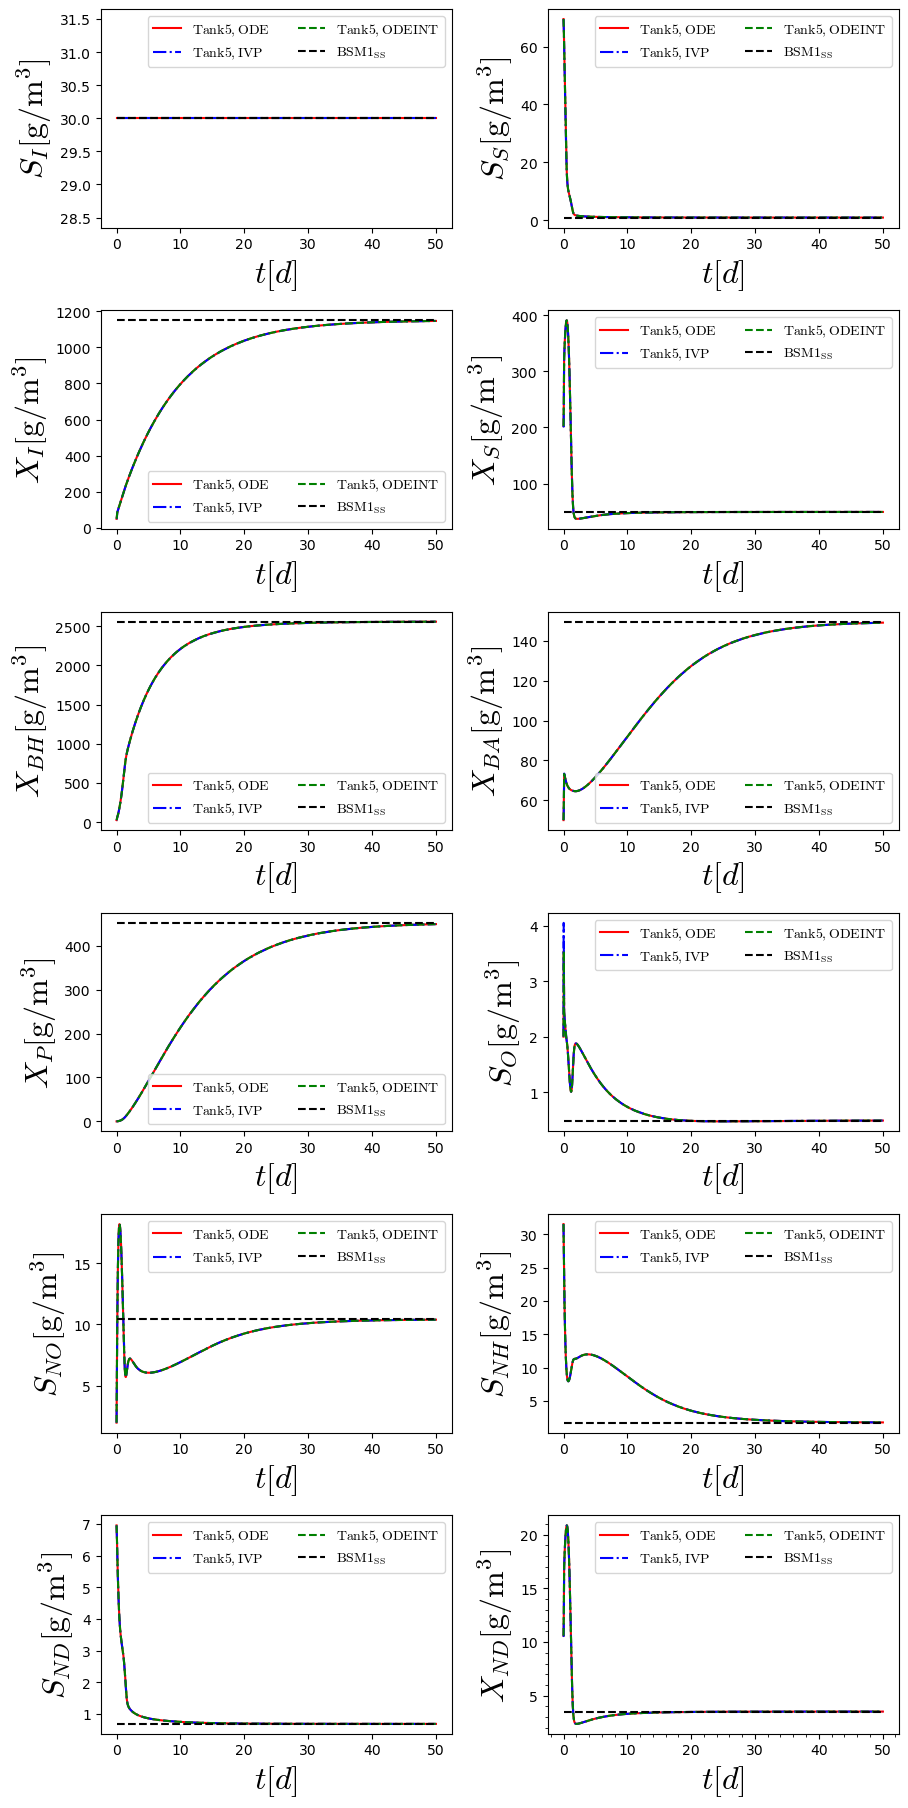

In [24]:
fig, axs = plt.subplots(6, 2, figsize=(9, 18))
plt.minorticks_on()

# Plot the soluble inert organic matter (SI)
axs[0, 0].plot(system_data_ode["time"], system_data_ode["SI5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[0, 0].plot(system_data_ivp["time"], system_data_ivp["SI5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[0, 0].plot(system_data_odeint["time"], system_data_odeint["SI5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[0, 0].plot([0, tEnd], [df_SS_outlet["SI"], df_SS_outlet["SI"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[0, 0].legend(fontsize=10, ncol=2)
axs[0, 0].set_xlabel(r'$t [d]$', fontsize=23)
axs[0, 0].set_ylabel(r'$S_I \mathrm{[g/m^3]}$', fontsize=23)

# Plot the readily biodegradable substrate (SS)
axs[0, 1].plot(system_data_ode["time"], system_data_ode["SS5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[0, 1].plot(system_data_ivp["time"], system_data_ivp["SS5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[0, 1].plot(system_data_odeint["time"], system_data_odeint["SS5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[0, 1].plot([0, tEnd], [df_SS_outlet["SS"], df_SS_outlet["SS"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[0, 1].legend(fontsize=10, ncol=2)
axs[0, 1].set_xlabel(r'$t [d]$', fontsize=23)
axs[0, 1].set_ylabel(r'$S_S \mathrm{[g/m^3]}$', fontsize=23)

# Plot the particulate inert organic matter (XI)
axs[1, 0].plot(system_data_ode["time"], system_data_ode["XI5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[1, 0].plot(system_data_ivp["time"], system_data_ivp["XI5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[1, 0].plot(system_data_odeint["time"], system_data_odeint["XI5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[1, 0].plot([0, tEnd], [df_SS_outlet["XI"], df_SS_outlet["XI"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[1, 0].legend(fontsize=10, ncol=2)
axs[1, 0].set_xlabel(r'$t [d]$', fontsize=23)
axs[1, 0].set_ylabel(r'$X_I \mathrm{[g/m^3]}$', fontsize=23)

# Plot the slowly biodegradable substrate (XS)
axs[1, 1].plot(system_data_ode["time"], system_data_ode["XS5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[1, 1].plot(system_data_ivp["time"], system_data_ivp["XS5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[1, 1].plot(system_data_odeint["time"], system_data_odeint["XS5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[1, 1].plot([0, tEnd], [df_SS_outlet["XS"], df_SS_outlet["XS"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[1, 1].legend(fontsize=10, ncol=2)
axs[1, 1].set_xlabel(r'$t [d]$', fontsize=23)
axs[1, 1].set_ylabel(r'$X_S \mathrm{[g/m^3]}$', fontsize=23)

# Plot the active heterotrophic biomass (XBH)
axs[2, 0].plot(system_data_ode["time"], system_data_ode["XBH5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[2, 0].plot(system_data_ivp["time"], system_data_ivp["XBH5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[2, 0].plot(system_data_odeint["time"], system_data_odeint["XBH5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[2, 0].plot([0, tEnd], [df_SS_outlet["XBH"], df_SS_outlet["XBH"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[2, 0].legend(fontsize=10, ncol=2)
axs[2, 0].set_xlabel(r'$t [d]$', fontsize=23)
axs[2, 0].set_ylabel(r'$X_{BH} \mathrm{[g/m^3]}$', fontsize=23)

# Plot the active autotrophic biomass (XBA)
axs[2, 1].plot(system_data_ode["time"], system_data_ode["XBA5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[2, 1].plot(system_data_ivp["time"], system_data_ivp["XBA5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[2, 1].plot(system_data_odeint["time"], system_data_odeint["XBA5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[2, 1].plot([0, tEnd], [df_SS_outlet["XBA"], df_SS_outlet["XBA"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[2, 1].legend(fontsize=10, ncol=2)
axs[2, 1].set_xlabel(r'$t [d]$', fontsize=23)
axs[2, 1].set_ylabel(r'$X_{BA} \mathrm{[g/m^3]}$', fontsize=23)

# Plot the particulate products arising from biomass decay (XP)
axs[3, 0].plot(system_data_ode["time"], system_data_ode["XP5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[3, 0].plot(system_data_ivp["time"], system_data_ivp["XP5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[3, 0].plot(system_data_odeint["time"], system_data_odeint["XP5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[3, 0].plot([0, tEnd], [df_SS_outlet["XP"], df_SS_outlet["XP"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[3, 0].legend(fontsize=10, ncol=2)
axs[3, 0].set_xlabel(r'$t [d]$', fontsize=23)
axs[3, 0].set_ylabel(r'$X_{P} \mathrm{[g/m^3]}$', fontsize=23)

# Plot the oxygen (SO)
axs[3, 1].plot(system_data_ode["time"], system_data_ode["SO5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[3, 1].plot(system_data_ivp["time"], system_data_ivp["SO5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[3, 1].plot(system_data_odeint["time"], system_data_odeint["SO5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[3, 1].plot([0, tEnd], [df_SS_outlet["SO"], df_SS_outlet["SO"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[3, 1].legend(fontsize=10, ncol=2)
axs[3, 1].set_xlabel(r'$t [d]$', fontsize=23)
axs[3, 1].set_ylabel(r'$S_O \mathrm{[g/m^3]}$', fontsize=23)

# Plot the nitrate and nitrite (SNO)
axs[4, 0].plot(system_data_ode["time"], system_data_ode["SNO5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[4, 0].plot(system_data_ivp["time"], system_data_ivp["SNO5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[4, 0].plot(system_data_odeint["time"], system_data_odeint["SNO5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[4, 0].plot([0, tEnd], [df_SS_outlet["SNO"], df_SS_outlet["SNO"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[4, 0].legend(fontsize=10, ncol=2)
axs[4, 0].set_xlabel(r'$t [d]$', fontsize=23)
axs[4, 0].set_ylabel(r'$S_{NO} \mathrm{[g/m^3]}$', fontsize=23)

# Plot the ammonia and ammonium nitrogen (SNH)
axs[4, 1].plot(system_data_ode["time"], system_data_ode["SNH5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[4, 1].plot(system_data_ivp["time"], system_data_ivp["SNH5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[4, 1].plot(system_data_odeint["time"], system_data_odeint["SNH5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[4, 1].plot([0, tEnd], [df_SS_outlet["SNH"], df_SS_outlet["SNH"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[4, 1].legend(fontsize=10, ncol=2)
axs[4, 1].set_xlabel(r'$t [d]$', fontsize=23)
axs[4, 1].set_ylabel(r'$S_{NH} \mathrm{[g/m^3]}$', fontsize=23)

# Plot the soluble biodegradable organic nitrogen (SND)
axs[5, 0].plot(system_data_ode["time"], system_data_ode["SND5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[5, 0].plot(system_data_ivp["time"], system_data_ivp["SND5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[5, 0].plot(system_data_odeint["time"], system_data_odeint["SND5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[5, 0].plot([0, tEnd], [df_SS_outlet["SND"], df_SS_outlet["SND"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[5, 0].legend(fontsize=10, ncol=2)
axs[5, 0].set_xlabel(r'$t [d]$', fontsize=23)
axs[5, 0].set_ylabel(r'$S_{ND} \mathrm{[g/m^3]}$', fontsize=23)

# Plot the particulate biodegradable organic nitrogen (XND)
axs[5,1].plot(system_data_ode["time"], system_data_ode["XND5"], 'r-', label=r'$\mathrm{Tank 5, ODE}$')
axs[5,1].plot(system_data_ivp["time"], system_data_ivp["XND5"], 'b-.', label=r'$\mathrm{Tank 5, IVP}$')
axs[5,1].plot(system_data_odeint["time"], system_data_odeint["XND5"], 'g--', label=r'$\mathrm{Tank 5, ODEINT}$')
axs[5,1].plot([0,tEnd], [df_SS_outlet["XND"],df_SS_outlet["XND"]], 'k--', label=r'$\mathrm{BSM1_{SS}}$')
axs[5,1].legend(fontsize=10, ncol=2)
axs[5,1].set_xlabel(r'$t [d]$', fontsize=23)
axs[5,1].set_ylabel(r'$X_{ND} \mathrm{[g/m^3]}$', fontsize=23)

fig.tight_layout(pad=0.4, w_pad=1, h_pad=1.0)

#fig.savefig('bsm1.svg',bbox_inches='tight')

plt.show()